In [80]:
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

import utils
import scoring

import os
import tempfile
import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

EPOCHS = 1000
BATCH_SIZE = 32
SHUFFLE = True
REPEATITION=50


log_dir = "./logs/fit2/"

#output folder for saving checkpoint
outputFolder = './output2'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
    
%load_ext tensorboard
# !rm -rf log_dir

2.2.0
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [81]:
# columns = utils.SIMPLE_FEATURE_COLUMNS + ["id", "label", "weight", "sWeight", "kinWeight"]
# DATA_PATH = "~/share/data/I-coopetition-muon-id/"
# train = pd.read_csv(os.path.join(DATA_PATH, "train.csv.gz"), index_col="id", usecols=columns)
# test = pd.read_csv(os.path.join(DATA_PATH, "test-features.csv.gz"), index_col="id", usecols=utils.SIMPLE_FEATURE_COLUMNS + ["id"])


columns = utils.SIMPLE_FEATURE_COLUMNS + ["id", "label", "weight",  "kinWeight"]
DATA_FOLDER = "~/share/data/1.6.2-boosting/"
data = pd.read_csv(os.path.join(DATA_FOLDER, "train_1_percent.csv"), index_col="id", usecols=columns)


new_key_label=[]
for name in data.columns:
    if '[' in name:
        name = name.replace('[', '_').replace(']', '')

    new_key_label.append(name)

data.columns = new_key_label

In [82]:
data.head(5)

,ncl_0,ncl_1,ncl_2,ncl_3,avg_cs_0,avg_cs_1,avg_cs_2,avg_cs_3,ndof,MatchedHit_TYPE_0,...,Mextra_DY2_0,Mextra_DY2_1,Mextra_DY2_2,Mextra_DY2_3,FOI_hits_N,PT,P,label,kinWeight,weight
id,,,,,,,,,,,,,,,,,,,,,
156079,24,2,11,13,2.333333,2.000000,1.727273,1.153846,8,2,...,609.451230,1758.819800,4016.10500,7918.94200,7,1699.454257,8692.546221,1,2.80650,2.431642
1129839,24,13,6,10,1.708333,1.769231,1.500000,1.400000,8,2,...,342.040680,989.623600,2251.83450,4411.09700,5,3381.439699,13378.001174,1,1.85646,2.259009
4263309,27,13,10,13,2.296296,1.384615,1.100000,2.000000,8,2,...,256.180200,744.244750,1684.75510,3292.70750,12,962.785246,13904.582780,1,3.77936,4.349500
199338,130,66,23,23,3.423077,3.045454,1.434783,1.565217,8,2,...,649.849800,1885.884300,4325.38430,8559.56000,64,810.190921,8565.752002,1,1.85646,-0.740073
2663246,85,61,18,20,3.294118,2.278688,1.222222,1.300000,8,2,...,12.617317,36.086983,79.09466,148.79881,10,1452.814360,64736.044173,1,1.85646,1.161770


In [83]:
# Use a utility from sklearn to split and shuffle our dataset.
train_df, test_df = train_test_split(data, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# train_ds = utils.df_to_dataset(train_df, shuffle=SHUFFLE, batch_size=BATCH_SIZE, repeatitions = REPEATITION)
# val_ds = utils.df_to_dataset(val_df, shuffle=SHUFFLE, batch_size=BATCH_SIZE, repeatitions = REPEATITION)
# test_ds = utils.df_to_dataset(test_df, shuffle=SHUFFLE, batch_size=BATCH_SIZE, repeatitions = REPEATITION)


# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('label'))
val_labels = np.array(val_df.pop('label'))
test_labels = np.array(test_df.pop('label'))
# val_weights = np.array(val_df.copy('weight'))
# val_weights = val_df['weight'].copy()

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


train_ds = utils.make_ds(train_features, train_labels , shuffle=SHUFFLE, batch_size=BATCH_SIZE, repeatitions = REPEATITION)
val_ds = utils.make_ds(val_features, val_labels,  shuffle=SHUFFLE, batch_size=BATCH_SIZE, repeatitions = REPEATITION)
# test_ds = utils.make_ds(test_features, test_labels, shuffle=SHUFFLE, batch_size=BATCH_SIZE, repeatitions = REPEATITION)

# val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels))#.cache()
# val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (8087,)
Validation labels shape: (2022,)
Test labels shape: (2528,)
Training features shape: (8087, 67)
Validation features shape: (2022, 67)
Test features shape: (2528, 67)


In [84]:


# for feature_batch, label_batch in train_ds.take(1):
#   print('Every feature:', list(feature_batch.keys()))
#   print('A batch of PT:', feature_batch['PT'])
#   print('A batch of targets:', label_batch )

# feature_columns = []
# feature_batch, label_batch = next(iter(train_ds))

# for header in list(feature_batch.keys()):
#     feature_columns.append(tf.feature_column.numeric_column(header))


# # # print(feature_columns)
# feature_layer = tf.keras.layers.DenseFeatures(feature_columns, dtype='float64')

In [85]:
METRICS = [
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

tf.keras.backend.set_floatx('float64')
def make_model(metrics = METRICS, output_bias=None):

  model = keras.Sequential([
#       keras.layers.Dense(1280, activation='relu', input_shape=(train_features.shape[-1],), name="layer1" ),
#       feature_layer,
      keras.layers.Dense(1280, activation='relu', name="layer1" ),
      keras.layers.Dense(640, activation='relu', name="layer2"),
      keras.layers.Dropout(.1, name="dropout1"),
      keras.layers.Dense(320, activation='relu', name="layer3"),
      keras.layers.Dropout(.05, name="dropout2"),
      keras.layers.Dense(160, activation='relu', name="layer4"),
      keras.layers.Dropout(.025, name="dropout3"),
      keras.layers.Dense(80, activation='relu', name="layer5"),
      keras.layers.Dropout(.0125, name="dropout4"),
      keras.layers.Dense(40, activation='relu', name="layer6"),
      keras.layers.Dense(20, activation='relu', name="layer7"),
      keras.layers.Dense(1, name="layer8"),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

#   model.compile(optimizer='rmsprop',
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=metrics)
    
  model.compile(
#       optimizer=keras.optimizers.Adam(lr=1e-3),
      optimizer='rmsprop',
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

#   model.compile(optimizer='adam',
#                 loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
#                 metrics=['accuracy'])



  return model



RESTORE = True
latest_ckpt = tf.train.latest_checkpoint(outputFolder)
print('found latest checkpoint----: ', latest_ckpt)

latest_model_ckpt = utils.latest_saved_model(outputFolder)

if latest_model_ckpt is not None and RESTORE:
    print('.....loading model from checkpoint: ', latest_model_ckpt)
    model = tf.keras.models.load_model(latest_model_ckpt)
    model_history = model.history
elif latest_ckpt is not None and RESTORE:
    model = make_model()
    model.load_weights(latest_ckpt).assert_consumed()
    print("Restored from {}".format(latest_ckpt))
    model_history = model.history
else:
    model = make_model()


# model.summary()


# Save the weights using the `checkpoint_path` format
# model.save_weights(checkpoint_path.format(epoch=0, val_auc=0))



early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)




checkpoint_path = outputFolder+"/model-{epoch:02d}_{val_auc:.4f}.ckpt"
# /model-{epoch:02d}-{val_auc:.2f}.ckpt"

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_auc',
                                                 save_weights_only=False,
                                                 verbose=1,
                                                 mode='max',
                                                 save_best_only=True)

cp_callback_weightOnly = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_auc',
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 mode='max',
                                                 save_best_only=True)


tensorboard_callback = tf.keras.callbacks.TensorBoard( log_dir=log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
                                                histogram_freq=1,
                                                write_graph=True,
                                                write_images=False,
                                                update_freq='epoch',
                                                profile_batch=2,
                                                embeddings_freq=0,
                                                embeddings_metadata=None,
                                                )


found latest checkpoint----:  None
found model checkpoint-----: ./output2/model-106_0.8672.ckpt
.....loading model from checkpoint:  ./output2/model-106_0.8672.ckpt


In [86]:
###TO-DO Write call back to save training history for every epoch
#https://github.com/tensorflow/tensorflow/issues/27861
#https://stackoverflow.com/questions/50127527/how-to-save-training-history-on-every-epoch-in-keras

# if (latest_ckpt is None  and latest_model_ckpt is  None) :
# model_history = model.fit(
#     train_features,
#     train_labels,
#     batch_size=BATCH_SIZE,
#     steps_per_epoch = 20,
#     epochs=EPOCHS,
#     shuffle=True,
#     callbacks = [early_stopping, cp_callback, tensorboard_callback],
#     validation_data=val_ds)
        #     validation_data=(val_features, val_labels))

if (latest_ckpt is None  and latest_model_ckpt is  None) :
    model_history = model.fit(
    train_ds,
#     batch_size=BATCH_SIZE,
    steps_per_epoch = 50,
    epochs=EPOCHS,
    shuffle=False,
    callbacks = [early_stopping, cp_callback, tensorboard_callback],
    validation_data=val_ds)

# model.fit(train_features,
#     train_labels,
#           validation_data=val_ds,
#           epochs=10)
# loss, accuracy = model.evaluate(test_ds)
# print("Accuracy", accuracy)



AttributeError: 'NoneType' object has no attribute 'epoch'

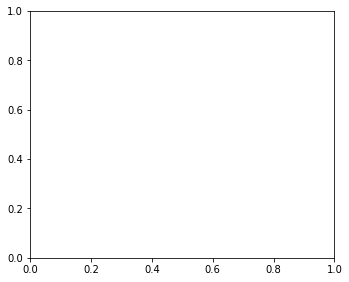

In [87]:
def plot_metrics(history):
  metrics =  ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.5,1])
    else:
      plt.ylim([0,1])

    plt.legend()

# with open(outputFolder+"history.json", 'w') as fp:
# json.dumps(str(model.history) )
    
plot_metrics(model_history)

In [0]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
val_predictions_baseline = model.predict(val_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))


baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [0]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
#   plt.xlim([-0.5,20])
#   plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [0]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[1], linestyle='--')
plot_roc("Validation Baseline", val_labels, val_predictions_baseline, color=colors[2], linestyle='-.')

plt.legend(loc='lower right')

In [0]:
# print(val_predictions_baseline)
# print(val_predictions_baseline.shape)
# val_predictions_baseline.flatten()
# print(val_predictions_baseline.flatten())
# print(val_labels)
# # val_weights = np.array(val_df.copy('weight'))
# # val_weights = val_df['weight'].copy().values
# # print(val_weights)

# print(len(val_predictions_baseline.flatten()))
# print(len(val_labels))
# print(len(val_weights))

In [0]:
scoring.rejection90(val_labels, val_predictions_baseline.flatten(), sample_weight=val_df['weight'].copy().values)